In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

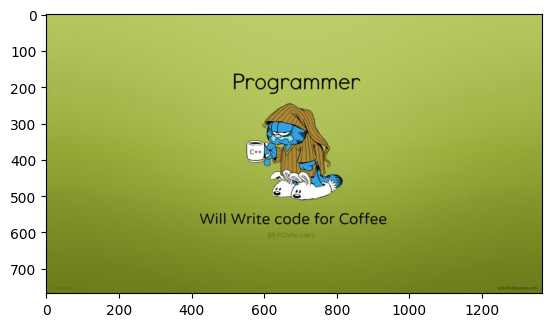

In [2]:
my_img = cv2.imread('RSA.jpg')
# cv2_imshow(my_img)
plt.imshow(my_img, cmap="gray")

In [3]:
#RSA

# STEP 1: Generate Two Large Prime Numbers (p,q) randomly
from random import randrange, getrandbits


def power(a,d,n):
  ans=1;
  while d!=0:
    if d%2==1:
      ans=((ans%n)*(a%n))%n
    a=((a%n)*(a%n))%n
    d>>=1
  return ans;


def MillerRabin(N,d):
  a = randrange(2, N - 1)
  x=power(a,d,N);
  if x==1 or x==N-1:
    return True;
  else:
    while(d!=N-1):
      x=((x%N)*(x%N))%N;
      if x==1:
        return False;
      if x==N-1:
        return True;
      d<<=1;
  return False;


def is_prime(N,K):
  if N==3 or N==2:
    return True;
  if N<=1 or N%2==0:
    return False;

  #Find d such that d*(2^r)=X-1
  d=N-1
  while d%2!=0:
    d/=2;

  for _ in range(K):
    if not MillerRabin(N,d):
      return False;
  return True;




def generate_prime_candidate(length):
  # generate random bits
  p = getrandbits(length)
  # apply a mask to set MSB and LSB to 1
  # Set MSB to 1 to make sure we have a Number of 1024 bits.
  # Set LSB to 1 to make sure we get a Odd Number.
  p |= (1 << length - 1) | 1
  return p



def generatePrimeNumber(length):
  A=4
  while not is_prime(A, 128):
        A = generate_prime_candidate(length)
  return A



length=5
P=generatePrimeNumber(length)
Q=generatePrimeNumber(length)

print(P)
print(Q)

19
19


In [4]:
#Step 2: Calculate N=P*Q and Euler Totient Function = (P-1)*(Q-1)
N=P*Q
eulerTotient=(P-1)*(Q-1)
print(N)
print(eulerTotient)

361
324


In [5]:
#Step 3: Find E such that GCD(E,eulerTotient)=1(i.e., e should be co-prime) such that it satisfies this condition:-  1<E<eulerTotient

def GCD(a,b):
  if a==0:
    return b;
  return GCD(b%a,a)

E=generatePrimeNumber(4)
while GCD(E,eulerTotient)!=1:
  E=generatePrimeNumber(4)
print(E)


11


In [6]:
# Step 4: Find D.
#For Finding D: It must satisfies this property:-  (D*E)Mod(eulerTotient)=1;
#Now we have two Choices
# 1. That we randomly choose D and check which condition is satisfying above condition.
# 2. For Finding D we can Use Extended Euclidean Algorithm: ax+by=1 i.e., eulerTotient(x)+E(y)=GCD(eulerTotient,e)
#Here, Best approach is to go for option 2.( Extended Euclidean Algorithm.)

def gcdExtended(E,eulerTotient):
  a1,a2,b1,b2,d1,d2=1,0,0,1,eulerTotient,E

  while d2!=1:

    # k
    k=(d1//d2)

    #a
    temp=a2
    a2=a1-(a2*k)
    a1=temp

    #b
    temp=b2
    b2=b1-(b2*k)
    b1=temp

    #d
    temp=d2
    d2=d1-(d2*k)
    d1=temp

    D=b2

  if D>eulerTotient:
    D=D%eulerTotient
  elif D<0:
    D=D+eulerTotient

  return D


D=gcdExtended(E,eulerTotient)
print(D)

59


In [7]:
row,col=my_img.shape[0],my_img.shape[1]
enc = [[0 for x in range(3000)] for y in range(3000)]

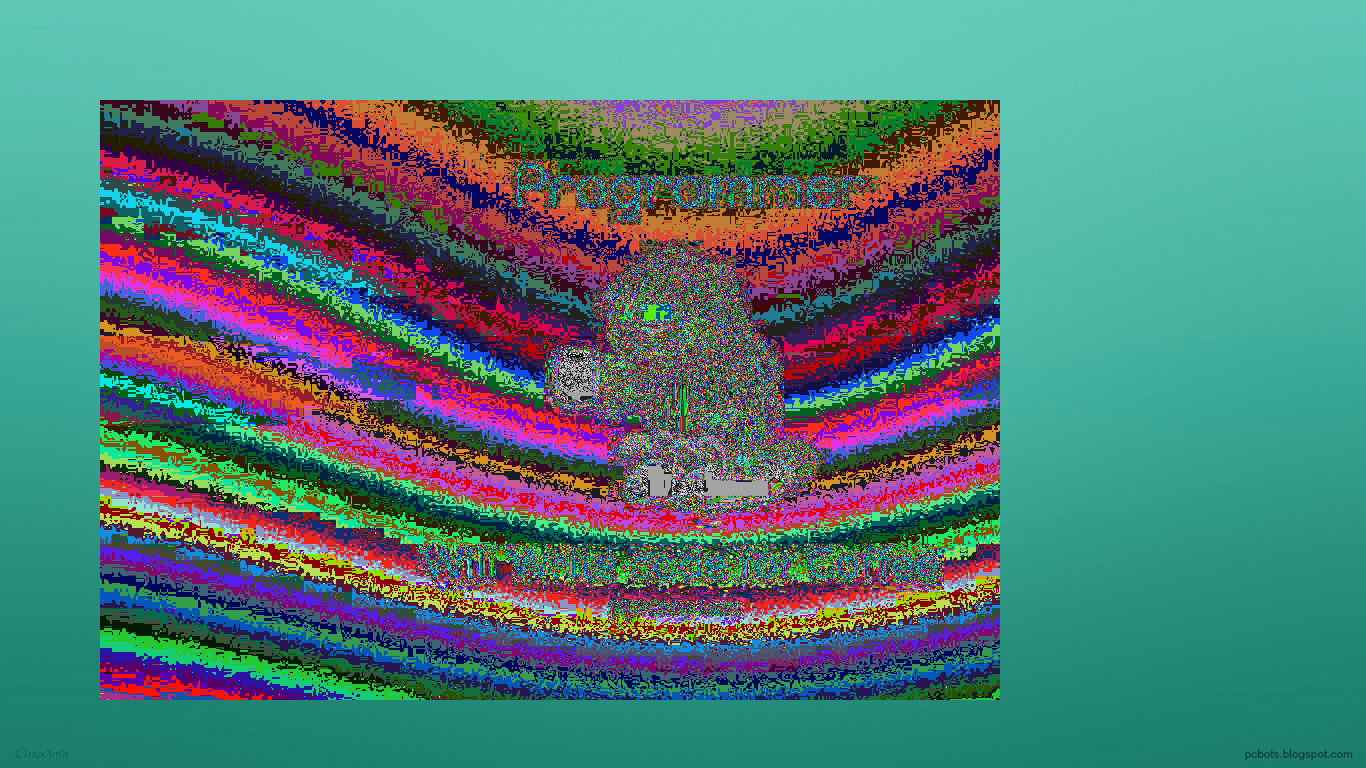

In [8]:
#Step 5: Encryption

for i in range(100,700):
  for j in range(100,1000):
    r,g,b=my_img[i,j]
    C1=power(r,E,N)
    C2=power(g,E,N)
    C3=power(b,E,N)
    enc[i][j]=[C1,C2,C3]
    C1=C1%256
    C2=C2%256
    C3=C3%256
    my_img[i,j]=[C1,C2,C3]


# plt.imshow(my_img, cmap="gray")
cv2_imshow(my_img)

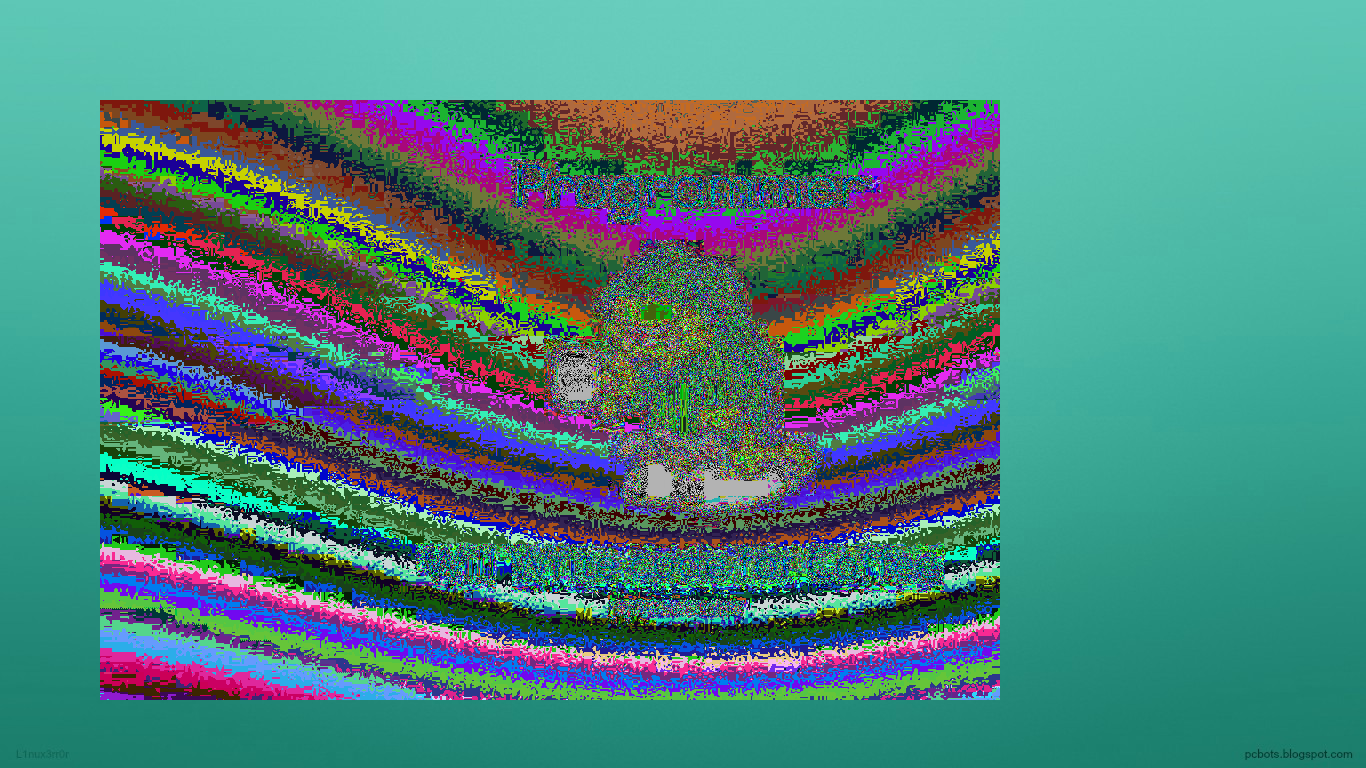

In [9]:
#Step 6: Decryption
for i in range(100,700):
  for j in range(100,1000):
    r,g,b=enc[i][j]
    M1=power(r,D,N)
    M2=power(g,D,N)
    M3=power(b,D,N)
    my_img[i,j]=[M1,M2,M3]

cv2_imshow(my_img)
# plt.imshow(my_img, cmap="gray")

In [10]:
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives import padding as sym_padding
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from PIL import Image
import os

# Load the image
input_image = "input_image.png"
output_encrypted_image = "encrypted_image.png"
output_decrypted_image = "decrypted_image.png"
image = Image.open(input_image)

# Generate RSA keys
private_key = rsa.generate_private_key(
    public_exponent=65537,
    key_size=2048,
    backend=default_backend()
)
public_key = private_key.public_key()

# Serialize the public key
pem = public_key.public_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PublicFormat.SubjectPublicKeyInfo
)

# Encrypt the image using AES
key = os.urandom(32)  # 256-bit key for AES
cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
encryptor = cipher.encryptor()
padder = sym_padding.PKCS7(128).padder()

# Serialize the private key
pem_private = private_key.private_bytes(
    encoding=serialization.Encoding.PEM,
    format=serialization.PrivateFormat.PKCS8,
    encryption_algorithm=serialization.NoEncryption()
)

# Save the public and private keys to files
with open("public_key.pem", "wb") as f:
    f.write(pem)

with open("private_key.pem", "wb") as f:
    f.write(pem_private)

# Encrypt the AES key using RSA
encrypted_key = public_key.encrypt(
    key,
    padding.OAEP(
        mgf=padding.MGF1(algorithm=hashes.SHA256()),
        algorithm=hashes.SHA256(),
        label=None
    )
)

# Encrypt the image data
image_data = image.tobytes()
padded_data = padder.update(image_data) + padder.finalize()
encrypted_data = encryptor.update(padded_data) + encryptor.finalize()

# Save the encrypted image
with open(output_encrypted_image, "wb") as f:
    f.write(encrypted_key)
    f.write(encrypted_data)

print("Image encrypted and saved as encrypted_image.png")

# Load the private key
with open("private_key.pem", "rb") as f:
    private_key = serialization.load_pem_private_key(f.read(), password=None, backend=default_backend())

# Decrypt the AES key using RSA
decrypted_key = private_key.decrypt(
    encrypted_key,
    padding.OAEP(
        mgf=padding.MGF1(algorithm=hashes.SHA256()),
        algorithm=hashes.SHA256(),
        label=None
    )
)

# Decrypt the image data
decryptor = cipher.decryptor()
decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()

# Save the decrypted image
with open(output_decrypted_image, "wb") as f:
    f.write(decrypted_data)

print("Image decrypted and saved as decrypted_image.png")


Image encrypted and saved as encrypted_image.png
Image decrypted and saved as decrypted_image.png
